In [1]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
load_dotenv()

# 임베딩 모델 준비
embedding_model = GoogleGenerativeAIEmbeddings(
    model="gemini-embedding-001",
)

In [2]:

from langchain_community.vectorstores import FAISS

# 벡터스토어 재로딩
vectorstore = FAISS.load_local(
    "faiss_index",
    embedding_model,
    allow_dangerous_deserialization=True,
)

In [3]:
# 예시 질의
query = "본 연구에서 Private LLM 구축을 위해 수집한 문서의 총 페이지 수와 문서 유형별 비율은 어떻게 되나요?"

In [4]:
# 리트리버 생성
retriever = vectorstore.as_retriever()

In [5]:
retriever.invoke(query)

[Document(id='809aa901-fec5-485a-8880-62ed0e723034', metadata={'producer': 'ezPDF Builder Supreme', 'creator': '', 'creationdate': '2024-12-27T02:09:00+09:00', 'source': '../data/KCI_FI003153549.pdf', 'file_path': '../data/KCI_FI003153549.pdf', 'total_pages': 12, 'format': 'PDF 1.6', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-12-27T02:09:00+09:00', 'trapped': '', 'modDate': "D:20241227020900+09'00'", 'creationDate': "D:20241227020900+09'00'", 'page': 4}, page_content='의료기기 임상시험 분야의 도메인 특성에 맞게 튜닝하\n기 위해 의료기기 임상시험 전문가로부터 총 158개의 문\n서(총 11,954 페이지)를 수집하였다. 수집된 문서는 다음\n과 같이 분류된다:\ny 규제 문서 (30%): FDA, EMA, PMDA 가이드라인, \nGCP 문서 등\ny 교육 자료 (20%): 임상시험 수행자 교육 매뉴얼, 온라\n인 강의 자료 등\ny 프로토콜 및 보고서 (25%): 임상시험 프로토콜, CSR \n(Clinical Study Report) 템플릿 등\ny 의료기기 특화 문서 (15%): 의료기기 임상시험 계획\n서, 기술문서 등\ny 기타 (10%): 윤리위원회 관련 문서, 환자 동의서 템플\n릿 등\n1.2 Validity of Collected Data\n수집된 \n데이터셋은 \n의료기기 \n임상시험에 \n특화된 \nPrivate LLM 구축을 위해 도메인 적합성과 다양성, 그리\n고 응용 가능성 측면에서 높은 타당성을 갖추고 있다. 

In [6]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [7]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색합니다.
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환합니다.

In [8]:

# LangChain의 hub에 정의된 검증된 RAG 프롬프트 활용
# https://smith.langchain.com/hub
# rlm: LangChain 팀이 공식적으로 유지보수하는 프롬프트를 의미
# rag-prompt: 해당 소유자가 게시한 프롬프트의 이름
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

In [9]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [10]:
def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    context = state['context']  # state에서 문맥을 추출합니다.
    query = state['query']      # state에서 사용자의 질문을 추출합니다.
    
    # RAG 체인을 구성합니다.
    rag_chain = prompt | llm
    
    # 질문과 문맥을 사용하여 응답을 생성합니다.
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}  # 생성된 응답을 포함하는 state를 반환합니다.

In [11]:
from langchain import hub

# 문서 관련성 판단을 위한 프롬프트
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

In [12]:

doc_relevance_prompt.messages[0].prompt.template

'You are a teacher grading a quiz. \n\nYou will be given a QUESTION and a set of FACTS provided by the student. \n\nHere is the grade criteria to follow:\n(1) You goal is to identify FACTS that are completely unrelated to the QUESTION\n(2) If the facts contain ANY keywords or semantic meaning related to the question, consider them relevant\n(3) It is OK if the facts have SOME information that is unrelated to the question (2) is met \n\nScore:\nA score of 1 means that the FACT contain ANY keywords or semantic meaning related to the QUESTION and are therefore relevant. This is the highest (best) score. \nA score of 0 means that the FACTS are completely unrelated to the QUESTION. This is the lowest possible score you can give.\n\nExplain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. \n\nAvoid simply stating the correct answer at the outset.'

In [14]:
from typing import Literal

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite'를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    context = state['context']  # state에서 문맥을 추출합니다.

    # 문서 관련성 판단 체인을 구성합니다.
    doc_relevance_chain = doc_relevance_prompt | llm
    
    # 질문과 문맥을 사용하여 문서의 관련성을 판단합니다.
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    # 관련성이 높으면 'generate'를 반환하고, 그렇지 않으면 'rewrite'를 반환합니다.
    if response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'

In [27]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 사전 정의: 특정 표현을 다른 표현으로 변환하기 위한 사전입니다.
dictionary = [
    '알잘딱깔센 -> Private LLM 구축을 위해 수집한 문서의 총 페이지 수와 문서 유형별 비율'
]

# 프롬프트 템플릿을 생성합니다. 사용자의 질문을 사전을 참고하여 변경합니다.
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state['query']  # state에서 사용자의 질문을 추출합니다.
    
    # 리라이트 체인을 구성합니다. 프롬프트, LLM, 출력 파서를 연결합니다.
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    # 질문을 변경합니다.
    response = rewrite_chain.invoke({'query': query})
    
    return {'query': response}  # 변경된 질문을 포함하는 state를 반환합니다.

In [28]:
from langgraph.graph import StateGraph
from langgraph.graph import START, END

graph_builder = StateGraph(AgentState)

graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance, {"generate": "generate", "rewrite": "rewrite"})
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

graph = graph_builder.compile()

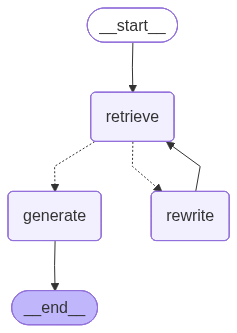

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [18]:
initial_state = {'query': query}
result = graph.invoke(initial_state)

Key 'parameters' is not supported in schema, ignoring


In [23]:
from pprint import pprint
pprint(result["answer"].content)

('본 연구에서 Private LLM 구축을 위해 수집한 문서의 총 페이지 수는 11,954페이지입니다. 문서 유형별 비율은 규제 문서 '
 '30%, 교육 자료 20%, 프로토콜 및 보고서 25%, 의료기기 특화 문서 15%, 기타 문서 10%입니다.')


In [30]:
initial_state = {'query': "알잘딱깔센은?"}
result = graph.invoke(initial_state)

Key 'parameters' is not supported in schema, ignoring
Key 'parameters' is not supported in schema, ignoring


In [31]:
result

{'query': '제안: **Private LLM 구축을 위해 수집한 문서의 총 페이지 수와 문서 유형별 비율은 무엇인가요?**',
 'context': [Document(id='809aa901-fec5-485a-8880-62ed0e723034', metadata={'producer': 'ezPDF Builder Supreme', 'creator': '', 'creationdate': '2024-12-27T02:09:00+09:00', 'source': '../data/KCI_FI003153549.pdf', 'file_path': '../data/KCI_FI003153549.pdf', 'total_pages': 12, 'format': 'PDF 1.6', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-12-27T02:09:00+09:00', 'trapped': '', 'modDate': "D:20241227020900+09'00'", 'creationDate': "D:20241227020900+09'00'", 'page': 4}, page_content='의료기기 임상시험 분야의 도메인 특성에 맞게 튜닝하\n기 위해 의료기기 임상시험 전문가로부터 총 158개의 문\n서(총 11,954 페이지)를 수집하였다. 수집된 문서는 다음\n과 같이 분류된다:\ny 규제 문서 (30%): FDA, EMA, PMDA 가이드라인, \nGCP 문서 등\ny 교육 자료 (20%): 임상시험 수행자 교육 매뉴얼, 온라\n인 강의 자료 등\ny 프로토콜 및 보고서 (25%): 임상시험 프로토콜, CSR \n(Clinical Study Report) 템플릿 등\ny 의료기기 특화 문서 (15%): 의료기기 임상시험 계획\n서, 기술문서 등\ny 기타 (10%): 윤리위원회 관련 문서, 환자 동의서 템플\n릿 등\n1.2 Validity of Collected Data\n수집된 \n데이터셋은 \n의